# Algoritmos de optimización - Reto 3
<br>
Alumno: Diego Miglino
<br>
Github: https://github.com/dmiglino/OptimizationAlgorithms/blob/main/Algoritmos_R3.ipynb
<br>

Me propuse a mejorar la búsqueda local, partiendo de una solución aleatoria que se iteró previamente 1000 veces buscando una mejor solución.

Para dicha mejora del algoritmo, agregue un mecanismo de multiarranque. En primer lugar, en cada iteración del multiarranque generaba una nueva solución totalmente aleatoria.

Luego implemente un mecanismo de perturbación del orden de los nodos, donde selecciono N grupos de M elementos y reordeno aleatoriamente cada grupo. Esto es con un fin diversificador, y fue notoria su implementación en los resultados obtenidos.

Con esta nueva funcionalidad, en el multiarranque, en vez de generar una solución aleatoria cada vez, uso una perturbación fuerte de los nodos. Es una modificación fuerte con valores de N y M más altos que además se adaptan dinámicamente según la cantidad de iteraciones sin mejores soluciones. Ambos puntos de inicio (aleatorio o perturbación) del multiarranque son diversificantes, pero al usar el método de la perturbación, puedo diversificar sin olvidar las buenas soluciones obtenidas, ya que si en cada iteración generamos una aleatoria, perdemos todo ese aprendizaje previo.

Además, tomando una idea de la búsqueda tabú, implemente una lista de soluciones ya evaluadas, para no repetir. No estoy guardando las permutaciones como en la lista tabú, sino que directamente guardo las soluciones completas. Cuando esto sucede, genero una perturbación menos fuerte de la solución, para volver a diversificar.

Dentro de la búsqueda local, intensifico la búsqueda generando pequeñas modificaciones en el orden de los nodos, no llega a ser una perturbación, sino que es simplemente explorar el vecindario con la técnica opt-2, donde se intercambian pares de nodos, buscando el óptimo local.
Si pasan N iteraciones sin mejoras, puedo estar atrapado en un óptimo local, así que hago perturbaciones buscando escapar. 
Si sigue sin haber mejorías luego de las perturbaciones, y pasan otras M iteraciones sin mejoras, freno la búsqueda local, y vuelvo a iterar desde el multiarranque.

El mejor resultado que obtuve fue 1304, y note que no hacen falta muchas iteraciones para obtener resultados similares. La configuración de parámetros de esa ejecución particular, hizo que la ejecución dure aproximadamente 13 minutos, pero el mejor resultado ya se habia hallado antes de la mitad de las iteraciones.

Parametros usados al encontrar la mejor solucion:


La mejor solución encontrada es: [34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 4, 3, 27, 2, 28, 29, 30, 38, 22, 39, 21, 24, 40, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 6, 1, 0, 32]
#### Distancia: 1304

Otra muy buena solucion: [0, 29, 30, 38, 22, 39, 24, 40, 21, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 6, 5, 13, 19, 14, 16, 15, 37, 7, 17, 31, 36, 35, 33, 20, 34, 32, 28, 2, 27, 3, 4, 1]
#### Distancia: 1354

#### Carga de librerias
Ejecutar solo la primera vez

In [8]:
#!pip install requests    #Hacer llamadas http a paginas de la red
#!pip install tsplib95    #Modulo para las instancias del problema del TSP

!pip install requests                     #Hacer llamadas http a paginas de la red
!pip install tabulate>=0.9 networkx>=3.0  # Actualiza las librerías 'tabulate' y 'networkx' a version compatibles con tsplib95
                                          # tabulate: Ayuda a crear tablas de texto legibles para presentar datos.
                                          # networkx:  Sirve para trabajar con grafos y redes, y realizar análisis sobre estas estructuras.
!pip install tsplib95 --no-deps           #Modulo para las instancias del problema del TSP
!pip install deprecated

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsplib95 0.7.1 requires networkx~=2.1, but you have networkx 3.2.1 which is incompatible.
tsplib95 0.7.1 requires tabulate~=0.8.7, but you have tabulate 0.9.0 which is incompatible.


#### Descarga y descompresion del problema
Ejecutar solo la primera vez

In [1]:
import urllib.request # Hacer llamadas http a paginas de la red

#http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95
#Documentacion :
  # http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
  # https://tsplib95.readthedocs.io/en/stable/pages/usage.html
  # https://tsplib95.readthedocs.io/en/v0.6.1/modules.html
  # https://pypi.org/project/tsplib95/

#Descargamos el fichero de datos(Matriz de distancias)
file = "swiss42.tsp" ;
urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/swiss42.tsp.gz", file + '.gz')
!gzip -y -d swiss42.tsp.gz     #Descomprimir el fichero de datos

#Coordendas 51-city problem (Christofides/Eilon)
#file = "eil51.tsp" ; urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/eil51.tsp.gz", file)

#Coordenadas - 48 capitals of the US (Padberg/Rinaldi)
#file = "att48.tsp" ; urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/att48.tsp.gz", file)


gzip: invalid option -- 'y'
Try `gzip --help' for more information.


#### Carga de los datos del problema

In [41]:
import tsplib95       #Modulo para las instancias del problema del TSP
import math           #Modulo de funciones matematicas. Se usa para exp
import random         #Para generar valores aleatorios

########################################################################
# Carga de datos y generación de objeto problem cn sus nodos y aristas #
########################################################################

file = "swiss42.tsp"

# Problema TSP
problem = tsplib95.load(file)

# Nodos
Nodos = list(problem.get_nodes())

# Aristas
Aristas = list(problem.get_edges())



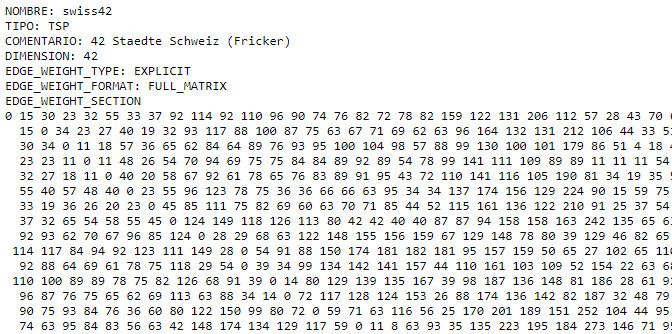

#### Funcionas basicas generales
Para crear una solucion aleatoria y para obtener la distancia total del recorrido.

In [42]:
##############################################################
##################### Funcionas basicas ######################
##############################################################

# Genera una solucion aleatoria comenzando desde el nodo 0
def crear_solucion(Nodos):
  solucion = [Nodos[0]]
  for n in Nodos[1:]:
    solucion = solucion + [random.choice(list(set(Nodos) - set({Nodos[0]}) - set(solucion)))]
  return solucion

# Devuelve la distancia entre dos nodos
def distancia(a,b, problem):
  return problem.get_weight(a,b)

# Devuelve la distancia total de un recorrido/solucion
def distancia_total(solucion, problem):
  distancia_total = 0
  for i in range(len(solucion)-1):
    distancia_total += distancia(solucion[i] ,solucion[i+1] ,  problem)
  return distancia_total + distancia(solucion[len(solucion)-1] ,solucion[0], problem)

# Probamos la generacion de una solucion aleatoria
sol_temporal = crear_solucion(Nodos)
print(f'{sol_temporal} = {distancia_total(sol_temporal, problem)}')

[0, 14, 36, 19, 16, 9, 10, 38, 35, 27, 25, 30, 31, 8, 37, 32, 23, 3, 34, 6, 33, 5, 13, 17, 26, 15, 20, 1, 24, 29, 2, 21, 7, 41, 22, 39, 12, 11, 40, 18, 4, 28] = 4701


### BUSQUEDA ALEATORIA
Algoritmo diversificante que genera N soluciones aleatorias y se queda con la mejor de ellas

In [43]:
###############################################################################
############################# BUSQUEDA ALEATORIA ##############################
###############################################################################

def busqueda_aleatoria(problem, N):
  #N es el numero de iteraciones
  Nodos = list(problem.get_nodes())

  mejor_solucion = []
  mejor_distancia = float('inf')                    # Inicializamos con un valor alto

  for i in range(N):                                # Se generan N soluciones aleatorias
    solucion = crear_solucion(Nodos)                
    distancia = distancia_total(solucion, problem)  # Calcula su distancia total

    if distancia < mejor_distancia:                 # Compara con la mejor obtenida hasta ahora
      mejor_solucion = solucion
      mejor_distancia = distancia

  return mejor_solucion                             # Se devuelve la mejor solucion encontrada


# Test de busqueda aleatoria con N iteraciones
solucion_aleatoria = busqueda_aleatoria(problem, 2000)
print(f'Solucion de busqueda aleatoria: {distancia_total(solucion_aleatoria, problem)}')

Solucion de busqueda aleatoria: 3742


### BUSQUEDA LOCAL

### PERTURBACION
Al detectar que durante N iteracion no se encontro mejor solucion, puede significar que caimos en un optimo local.
Con la perturbacion pretendo generar cambios significativos en la mejor solucion encontrada hasta el momento, para escapar de ese optimo.
La idea es agarrar N grupos de M elementos y reordenarlos aleatoriamente.

Esta perturbacion es a la vez DIVERSIFICANTE e INTENSIFICANTE, porque la perturbacion se hace sobre una solucion buena conocida, pero al mismo tiempo queremos escapar de ese optimo, por lo que agitamos lo suficiente para diversificar, pero no tan lejos de donde estamos.

Cabe aclarar con con este metodo diversificante, estamos aceptando momentaneamente soluciones peores que la actual.

Cuando tamano_grupo = 3, se comporta como un opt-3

In [44]:
def perturbar(solucion, tamano_grupo=2, num_grupos=8):
    nodos = solucion[:]
    n = len(nodos)
    
    inicio_limite = 0
    fin_limite = n - tamano_grupo - 0
    
    for _ in range(num_grupos):
        # Se elije un indice aleatorio para realizar el reordenamiento del grupo
        start = random.randint(inicio_limite, fin_limite)
        # Obtenemos el grupo en cuestion
        grupo = nodos[start:start+tamano_grupo]
        # Se reordena aleatoriamente
        random.shuffle(grupo)
        # Regeneramos el listado de nodos
        nodos[start:start+tamano_grupo] = grupo
        
    return nodos

# Prueba de perturbacion de una solucion dada
print(f'{solucion_aleatoria} = {distancia_total(solucion_aleatoria, problem)}')
perturbada = perturbar(solucion_aleatoria)
print(f'{perturbada} = {distancia_total(perturbada, problem)}')


[0, 28, 6, 15, 34, 22, 10, 9, 35, 31, 14, 19, 16, 30, 5, 7, 4, 32, 2, 27, 36, 11, 1, 24, 40, 21, 39, 18, 41, 8, 38, 13, 3, 25, 26, 23, 12, 29, 20, 33, 17, 37] = 3742
[0, 28, 6, 15, 34, 22, 10, 9, 35, 31, 14, 19, 16, 30, 5, 7, 4, 2, 32, 27, 36, 11, 1, 40, 24, 21, 39, 18, 41, 8, 38, 13, 3, 25, 26, 12, 23, 29, 20, 33, 17, 37] = 3653


#### GENERA VECINA
Algoritmo intensificante que dada una solucion va intercambiando pares de nodos de posicion y se queda con la mejor combinacion.

Agrega una logica para verificar si una solucion ya fue explorada, en ese caso, se genera una perturbacion sobre ella.

In [45]:
soluciones_analizadas = []

def genera_vecina(solucion):

  if solucion in soluciones_analizadas:
      # Si ya se habia explorado esta solucion, la perturbamos para diversificar cerca de ella
      solucion = perturbar(solucion)
      
  # Generador de soluciones vecinas: 2-opt (intercambiar 2 nodos) Si hay N nodos se generan (N-1)x(N-2)/2 soluciones
  mejor_solucion = []
  mejor_distancia = float('inf')

  #Recorremos todos los nodos en bucle doble para evaluar todos los intercambios 2-opt
  for i in range(0,len(solucion)-1):
    for j in range(i+1, len(solucion)):

      # Se genera una nueva solución intercambiando los dos nodos i,j
      vecina = solucion[:i] + [solucion[j]] + solucion[i+1:j] + [solucion[i]] + solucion[j+1:]

      # Se evalua la nueva solución
      distancia_vecina = distancia_total(vecina, problem)

      # La guardamos si mejora las anteriores
      if distancia_vecina <= mejor_distancia:
        mejor_distancia = distancia_vecina
        mejor_solucion = vecina

  if mejor_solucion not in soluciones_analizadas:
    soluciones_analizadas.append(mejor_solucion)
      
  return mejor_solucion


print("Distancia Solucion Incial Aleatoria:" , distancia_total(solucion_aleatoria, problem))
nueva_solucion = genera_vecina(solucion_aleatoria)
print("Distancia Mejor Solucion Local:", distancia_total(nueva_solucion, problem))


Distancia Solucion Incial Aleatoria: 3742
Distancia Mejor Solucion Local: 3426


In [46]:
###############################################################################
# BUSQUEDA LOCAL
###############################################################################
def busqueda_local(solucion, problem, tolerancia_iter_perturbacion, tolerancia_iter_sin_cambios):
  
  mejor_solucion = solucion
  solucion_referencia = solucion
  mejor_distancia = distancia_total(solucion_referencia, problem)
  iteracion = 0
  vueltas_sin_cambios = 0
    
  while(1):
    iteracion += 1 # Incrementamos el contador

    # Obtenemos la mejor vecina usando opt-2
    vecina = genera_vecina(solucion_referencia)

    # La evaluamos para ver si mejoramos respecto a lo encontrado hasta el momento
    distancia_vecina = distancia_total(vecina, problem)

    # Si la nueva solucion encontrada es mejor que la menor actual, la nueva se convertira en la mejor por el momento
    if distancia_vecina < mejor_distancia:
      mejor_solucion = vecina
      mejor_distancia = distancia_vecina
      vueltas_sin_cambios = 0

    # Si pasan N iteraciones sin encontrar mejores soluciones, se llego a un optimo local y finalizamos el proceso.
      ### (optimo regional lo llamaria yo, dado que con las perturbaciones estamos explorando la region/vecindad)
    elif vueltas_sin_cambios > tolerancia_iter_sin_cambios:
        return mejor_solucion

    # Si pasan N iteracion sin encontrar mejores soluciones, antes de finalizar, vamos a perturbar/agitar la mejor solucion actual.
      ### La idea es escapar del optimo local pero sin generar una nueva solucion que no tengan en cuenta lo hecho hasta el momento.
    elif vueltas_sin_cambios > tolerancia_iter_perturbacion:
      # perturbar solucion, diversifica pero sobre una buena base
      vecina = perturbar(mejor_solucion, 2, 6)
      distancia_vecina = distancia_total(vecina, problem)
      vueltas_sin_cambios += 1
        
      # Verificamos si la perturbacion genero una mejor solucion antes de seguir iterando
      if distancia_vecina < mejor_distancia:
          mejor_solucion = vecina
          mejor_distancia = distancia_vecina
          vueltas_sin_cambios = 0

    # Si no se cumple ninguna condicion, contabilizamos como una vuelta sin cambios
    else:
        vueltas_sin_cambios += 1
        
    solucion_referencia = vecina


#### MULTIARRANQUE

Buscando diversificar 100%, la idea es ejecutar la busqueda local N veces partiendo siempre de una solucion aleatoria diferente.
Dentro de cada busqueda local es donde vamos a buscar vecinas y perturbar, pero cada iteracion es una DIVERSIFICACION.


In [47]:
def con_multiarranque(nueva_solucion_vecina, parametros):  
    mejor_solucion_global = nueva_solucion_vecina
    mejor_distancia_global = distancia_total(nueva_solucion_vecina, problem)
    iter_sin_mejora = 0  # Contador global de iteraciones sin mejora
    
    for i in range(parametros['iteraciones_diversificar_local']):
        print(i, end=',')
        # busqueda local: se busca la mejor solucion dentro del vecindario (intensificacion) y cuando no se puede, se perturba la solucion (diversificacion)
        nueva_sol_local = busqueda_local(nueva_solucion_vecina, problem, parametros['tolerancia_perturbacion'], parametros['tolerancia_sin_cambios'])
        nueva_distancia = distancia_total(nueva_sol_local, problem)
        #print(f'{i} - Nueva: {nueva_distancia}, Vieja: {mejor_distancia_global}')
        
        if nueva_distancia <= mejor_distancia_global:
            iter_sin_mejora = 0
            mejor_distancia_global = nueva_distancia
            mejor_solucion_global = nueva_sol_local
            print(f'\n{i} --- Nueva Mejor Distancia Encontrada: {mejor_distancia_global}')
        else:
            iter_sin_mejora += 1

        # En cada iteracion hacemos una busqueda aleatoria para diversificar con una nueva solucion que nada tenga que ver con las anteriores
        # solucion = busqueda_aleatoria(problem, parametros['iteraciones_intensificar_aleatoria']) # DIVERSIFICACION
        
        # En vez de una busqueda aleatoria, me parece mejor hacer una perturbacion muy fuerte, tanto que podria parecerse a una aleatoria.
        ### Ajusto dinámicamente los parámetros de perturbación segun la cantidad de iteraciones sin mejoras..
        tamano, cantidad = ajustar_parametros_perturbacion(iter_sin_mejora, parametros)
        solucion = perturbar(mejor_solucion_global, tamano, cantidad) # DIVERSIFICACION sin barajar 100% nuevamente
        
        # Igualmente, dentro de esta nueva solucion, buscamos la mejor dentro de su vecindario para usarla en la busqueda local
        nueva_solucion_vecina = genera_vecina(solucion)

    return mejor_solucion_global
    

Ajusta dinámicamente los parámetros de perturbación según el número de iteraciones sin mejora.
Por ejemplo, cada 10 iteraciones sin mejora incrementamos el tamaño del grupo en 1 y la cantidad de grupos en 2.

In [48]:
def ajustar_parametros_perturbacion(vueltas_sin_mejora, parametros_iniciales):
    incremento = vueltas_sin_mejora // (parametros_iniciales['iteraciones_diversificar_local'] / 10)  # Cada N iteraciones sin mejora se incrementa
    tamano_grupo = parametros_iniciales['tamano_grupo_perturbacion_fuerte'] + incremento
    cantidad_grupos = parametros_iniciales['cantidad_grupos_perturbacion_fuerte'] + 2 * incremento
    return int(tamano_grupo), int(cantidad_grupos)

#### TEST
Sobre la Busqueda Local opt-2 (para intensificar la busqueda), usando perturbaciones (para escapar de optimos locales), una lista de soluciones ya evaluadas (para seguir ayudando a escapar de optimos locales) y con multiarranque (se ejecuta N veces para diversificar con soluciones que surgen de una fuerte perturbacion de la mejor conseguida hasta el momento)

#### Mejor solucion encontrada en mis ejecuciones: 1304
Utilizando los siguientes parametros: 
   - 'iteraciones_diversificar_local' : 25,
   - 'tolerancia_perturbacion' : 20,
   - 'tolerancia_sin_cambios' : 40,
   - 'tamano_grupo_perturbacion' : 3,
   - 'cantidad_grupos_perturbacion' : 5,
   - 'tamano_grupo_perturbacion_fuerte' : 5,
   - 'cantidad_grupos_perturbacion_fuerte' : 13

Tal vez con mas iteraciones en el multiarranque, los parametros para perturbar la solucion inicial hubiesen crecido tanto como para escapar de este optimo obtenido y seguir explorando regiones mucho mas alejadas. <br>
Tambien podria hacer que dadas N iteraciones sin mejoras, directamente hacer busqueda aleatoria en vez de la perturbacion fuerte.

In [49]:
%%time

# TEST busqueda local opt-2 con multiarranque y perturbaciones.
# Contrariamente a mi intuicion, no hace falta una gran cantidad de iteraciones.

soluciones_analizadas = []
parametros = {
    'iteraciones_diversificar_local' : 25,
    'iteraciones_intensificar_aleatoria' : 1000, # deprecado
    'tolerancia_perturbacion' : 20,
    'tolerancia_sin_cambios' : 40,
    'tamano_grupo_perturbacion' : 3,
    'cantidad_grupos_perturbacion' : 5,
    'tamano_grupo_perturbacion_fuerte' : 5,
    'cantidad_grupos_perturbacion_fuerte' : 13
}

mejor_global = con_multiarranque(solucion_aleatoria, parametros)

print("\n\nSe inicio con la solucion aleatoria:", distancia_total(nueva_solucion, problem))
print("La mejor solución encontrada es:" , mejor_global)
print("Distancia:" , distancia_total(mejor_global, problem))

0,
0 --- Nueva Mejor Distancia Encontrada: 1495
1,
1 --- Nueva Mejor Distancia Encontrada: 1387
2,3,4,
4 --- Nueva Mejor Distancia Encontrada: 1372
5,
5 --- Nueva Mejor Distancia Encontrada: 1371
6,
6 --- Nueva Mejor Distancia Encontrada: 1353
7,8,9,
9 --- Nueva Mejor Distancia Encontrada: 1349
10,11,
11 --- Nueva Mejor Distancia Encontrada: 1304
12,13,14,15,16,17,18,19,20,21,22,23,24,

Se inicio con la solucion aleatoria: 3426
La mejor solución encontrada es: [34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 4, 3, 27, 2, 28, 29, 30, 38, 22, 39, 21, 24, 40, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 6, 1, 0, 32]
Distancia: 1304
CPU times: user 13min 20s, sys: 111 ms, total: 13min 20s
Wall time: 13min 27s


#### Representación en un grafo a partir de la matriz de distancias (Optimización de posiciones usando escalado multidimensional (MDS)


Multidimensional scaling problem(MDS):   https://en.wikipedia.org/wiki/Multidimensional_scaling

In [50]:
import numpy as npmejor_solucion_global
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS  # Multidimensional Scaling o Escalado Multidimensional

def plot_tsp_solution(distance_matrix, tsp_solution):
    """
    Dibuja el grafo de un TSP con las posiciones calculadas mediante MDS y muestra
    solo las aristas correspondientes a la solución del TSP.

    :param distance_matrix: np.ndarray, matriz de distancias entre nodos
    :param tsp_solution: list, lista de nodos en el orden de la solución del TSP
    """
    # Crear el grafo completo
    G = nx.Graph()
    num_nodes = len(distance_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G.add_edge(i, j, weight=distance_matrix[i][j])

    # Usar MDS para calcular posiciones de los nodos
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    positions = mds.fit_transform(distance_matrix)

    # Convertir las posiciones en un diccionario para networkx
    pos = {i: positions[i] for i in range(num_nodes)}

    # Crear un subgrafo con las aristas del camino TSP
    TSP_G = nx.Graph()
    for i in range(len(tsp_solution) - 1):
        u = tsp_solution[i]
        v = tsp_solution[i + 1]
        TSP_G.add_edge(u, v, weight=distance_matrix[u][v])

    # Dibujar el grafo
    plt.figure(figsize=(14, 8))

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

    # Dibujar las aristas del camino TSP
    nx.draw_networkx_edges(TSP_G, pos, edge_color='red', width=2)

    # Añadir etiquetas a los nodos y pesos de las aristas
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(TSP_G, 'weight')
    nx.draw_networkx_edge_labels(TSP_G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Grafo TSP con solución específica")
    plt.show()


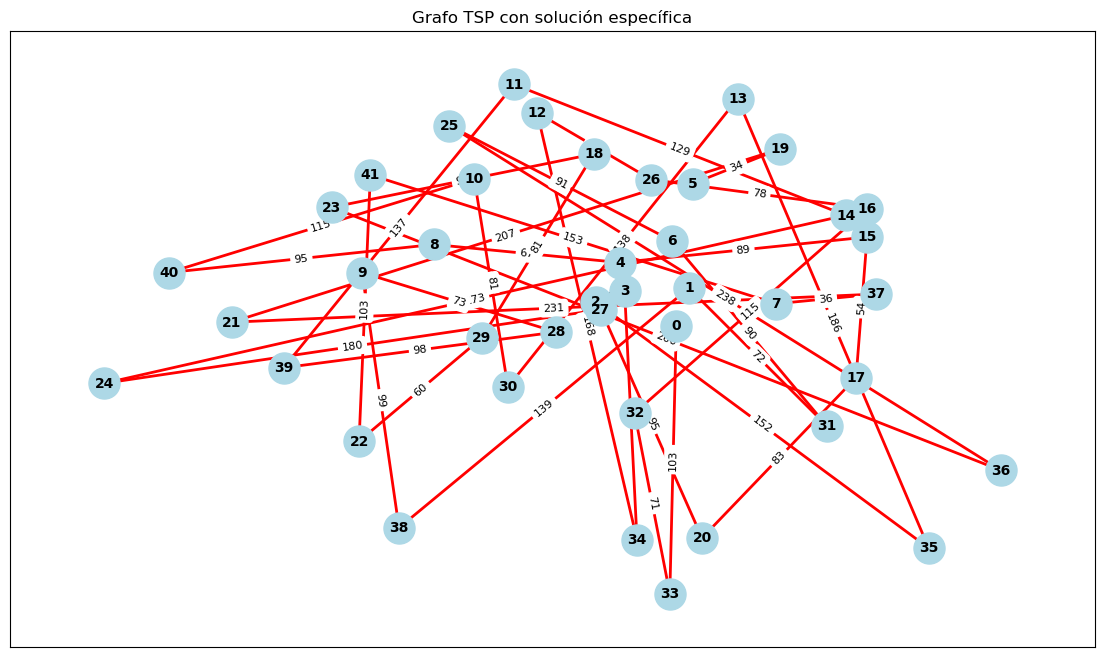

Camino: [0, 33, 32, 16, 26, 12, 34, 3, 2, 35, 13, 30, 10, 40, 8, 4, 15, 17, 20, 27, 24, 14, 11, 39, 28, 9, 38, 1, 31, 6, 25, 36, 23, 18, 29, 22, 41, 7, 37, 21, 19, 5]
Distancia: 4780


In [37]:
random = crear_solucion(Nodos)
plot_tsp_solution(problem.edge_weights, random)
print("Camino:" , random)
print("Distancia:" , distancia_total(random, problem))

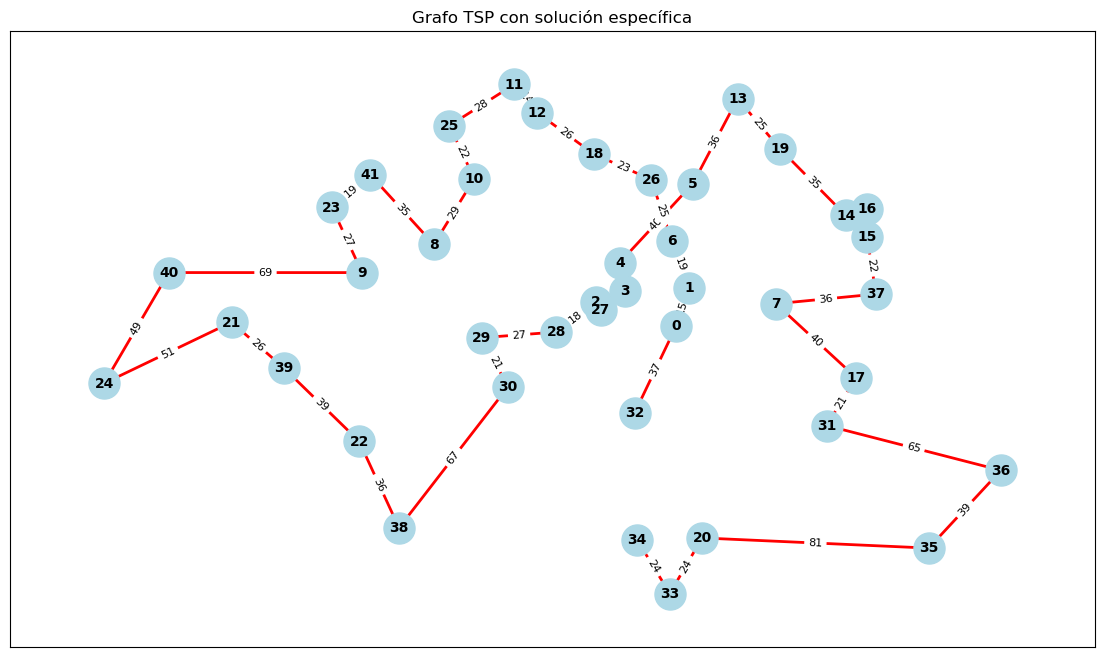

Camino: [34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 4, 3, 27, 2, 28, 29, 30, 38, 22, 39, 21, 24, 40, 9, 23, 41, 8, 10, 25, 11, 12, 18, 26, 6, 1, 0, 32]
Distancia: 1304


In [51]:
# Mejor solucion encontrada
plot_tsp_solution(problem.edge_weights, mejor_global)
print("Camino:" , mejor_global)
print("Distancia:" , distancia_total(mejor_global, problem))

### Prueba manual..
Viendo el grafo de arriba, se ve que dando vuelta en espejo el subgrafo izquierdo, se puede obtener un menor camino.
El algoritmo no lo encontro, pero quise armar el camino manualmente para probarlo, y me dio una distancia de 1274

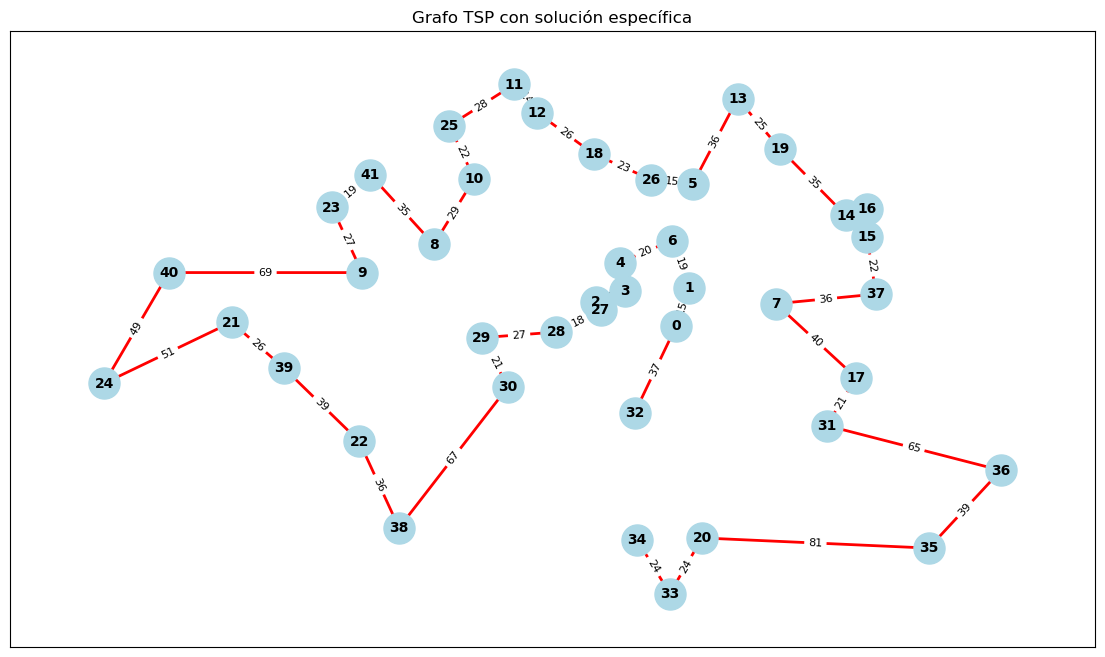

Camino: [34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1, 0, 32]
Distancia: 1274


In [58]:
test_manual = [34, 33, 20, 35, 36, 31, 17, 7, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 41, 23, 9, 40, 24, 21, 39, 22, 38, 30, 29, 28, 27, 2, 3, 4, 6, 1, 0, 32]
plot_tsp_solution(problem.edge_weights, test_manual)
print("Camino:" , test_manual)
print("Distancia:" , distancia_total(test_manual, problem))